CREATION DU FICHIER ORIGINAL

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import gc
import re
import time
from contextlib import contextmanager
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import xgboost as xgb
from xgboost import XGBClassifier

import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier

In [2]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=False, k=5):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == "object"]
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]

    # Utiliser KNNImputer uniquement sur les nouvelles colonnes
    if df[new_columns].isnull().sum().sum() > 0:
        imputer = KNNImputer(n_neighbors=k)
        df[new_columns] = imputer.fit_transform(df[new_columns])

    return df, new_columns

In [3]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows=None, nan_as_category=True):
    # Read data and merge
    df = pd.read_csv("../Data/Raw/application_train.csv", nrows=num_rows)
    test_df = pd.read_csv("../Data/Raw/application_test.csv", nrows=num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = pd.concat([df, test_df], ignore_index=True)
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df["CODE_GENDER"] != "XNA"]

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ["CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY"]:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df["DAYS_EMPLOYED"].replace(365243, np.nan, inplace=True)

    if df["TARGET"].isna().any():
        # Sélectionner uniquement les colonnes numériques
        numeric_cols = df.select_dtypes(include=["number"])

        # Exclure la colonne 'TARGET'
        numeric_cols = numeric_cols.drop(columns=["TARGET"])

        # Remplir les valeurs manquantes dans les colonnes numériques avec la moyenne de chaque colonne
        df[numeric_cols.columns] = numeric_cols.apply(
            lambda col: col.fillna(col.mean())
        )

    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # Some simple new features (percentages)
    df["DAYS_EMPLOYED_PERC"] = df["DAYS_EMPLOYED"] / df["DAYS_BIRTH"]
    df["INCOME_CREDIT_PERC"] = df["AMT_INCOME_TOTAL"] / df["AMT_CREDIT"]
    df["INCOME_PER_PERSON"] = df["AMT_INCOME_TOTAL"] / df["CNT_FAM_MEMBERS"]
    df["ANNUITY_INCOME_PERC"] = df["AMT_ANNUITY"] / df["AMT_INCOME_TOTAL"]
    df["PAYMENT_RATE"] = df["AMT_ANNUITY"] / df["AMT_CREDIT"]
    del test_df
    gc.collect()
    return df

In [4]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows=None, nan_as_category=True):
    bureau = pd.read_csv("../Data/Raw/bureau.csv", nrows=num_rows)
    bb = pd.read_csv("../Data/Raw/bureau_balance.csv", nrows=num_rows)

    threshold = 0.5 * len(bb)
    bb = bb.dropna(thresh=threshold, axis=1)
    threshold1 = 0.5 * len(bureau)
    bureau = bureau.dropna(thresh=threshold1, axis=1)

    # Sélectionner uniquement les colonnes numériques
    numeric_cols = bureau.select_dtypes(include=["number"])

    # Remplir les valeurs manquantes dans les colonnes numériques avec la moyenne de chaque colonne
    bureau[numeric_cols.columns] = numeric_cols.apply(
        lambda col: col.fillna(col.mean())
    )

    # Sélectionner uniquement les colonnes numériques
    numeric_cols1 = bb.select_dtypes(include=["number"])

    # Remplir les valeurs manquantes dans les colonnes numériques avec la moyenne de chaque colonne
    bb[numeric_cols1.columns] = numeric_cols1.apply(lambda col: col.fillna(col.mean()))

    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {"MONTHS_BALANCE": ["min", "max", "size"]}
    for col in bb_cat:
        bb_aggregations[col] = ["mean"]
    bb_agg = bb.groupby("SK_ID_BUREAU").agg(bb_aggregations)
    bb_agg.columns = pd.Index(
        [e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()]
    )
    bureau = bureau.join(bb_agg, how="left", on="SK_ID_BUREAU")
    bureau.drop(["SK_ID_BUREAU"], axis=1, inplace=True)
    del bb, bb_agg
    gc.collect()

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        "DAYS_CREDIT": ["min", "max", "mean", "var"],
        "DAYS_CREDIT_ENDDATE": ["min", "max", "mean"],
        "DAYS_CREDIT_UPDATE": ["mean"],
        "CREDIT_DAY_OVERDUE": ["max", "mean"],
        "AMT_CREDIT_SUM": ["max", "mean", "sum"],
        "AMT_CREDIT_SUM_DEBT": ["max", "mean", "sum"],
        "AMT_CREDIT_SUM_OVERDUE": ["mean"],
        "AMT_CREDIT_SUM_LIMIT": ["mean", "sum"],
        "CNT_CREDIT_PROLONG": ["sum"],
        "MONTHS_BALANCE_MIN": ["min"],
        "MONTHS_BALANCE_MAX": ["max"],
        "MONTHS_BALANCE_SIZE": ["mean", "sum"],
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat:
        cat_aggregations[cat] = ["mean"]
    for cat in bb_cat:
        cat_aggregations[cat + "_MEAN"] = ["mean"]

    bureau_agg = bureau.groupby("SK_ID_CURR").agg(
        {**num_aggregations, **cat_aggregations}
    )
    bureau_agg.columns = pd.Index(
        ["BURO_" + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()]
    )
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau["CREDIT_ACTIVE_Active"] == 1]
    active_agg = active.groupby("SK_ID_CURR").agg(num_aggregations)
    active_agg.columns = pd.Index(
        ["ACTIVE_" + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()]
    )
    bureau_agg = bureau_agg.join(active_agg, how="left", on="SK_ID_CURR")
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau["CREDIT_ACTIVE_Closed"] == 1]
    closed_agg = closed.groupby("SK_ID_CURR").agg(num_aggregations)
    closed_agg.columns = pd.Index(
        ["CLOSED_" + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()]
    )
    bureau_agg = bureau_agg.join(closed_agg, how="left", on="SK_ID_CURR")

    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [5]:
# Preprocess previous_applications.csv
def previous_applications(num_rows=None, nan_as_category=True):
    prev = pd.read_csv("../Data/Raw/previous_application.csv", nrows=num_rows)

    threshold = 0.5 * len(prev)
    prev = prev.dropna(thresh=threshold, axis=1)

    # Sélectionner uniquement les colonnes numériques
    numeric_cols = prev.select_dtypes(include=["number"])

    # Remplir les valeurs manquantes dans les colonnes numériques avec la moyenne de chaque colonne
    prev[numeric_cols.columns] = numeric_cols.apply(lambda col: col.fillna(col.mean()))

    prev, cat_cols = one_hot_encoder(prev, nan_as_category=False)
    # Days 365.243 values -> nan
    prev["DAYS_FIRST_DRAWING"].replace(365243, np.nan, inplace=True)
    prev["DAYS_FIRST_DUE"].replace(365243, np.nan, inplace=True)
    prev["DAYS_LAST_DUE_1ST_VERSION"].replace(365243, np.nan, inplace=True)
    prev["DAYS_LAST_DUE"].replace(365243, np.nan, inplace=True)
    prev["DAYS_TERMINATION"].replace(365243, np.nan, inplace=True)
    # Add feature: value ask / value received percentage
    prev["APP_CREDIT_PERC"] = prev["AMT_APPLICATION"] / prev["AMT_CREDIT"]
    # Previous applications numeric features
    num_aggregations = {
        "AMT_ANNUITY": ["min", "max", "mean"],
        "AMT_APPLICATION": ["min", "max", "mean"],
        "AMT_CREDIT": ["min", "max", "mean"],
        "APP_CREDIT_PERC": ["min", "max", "mean", "var"],
        "AMT_GOODS_PRICE": ["min", "max", "mean"],
        "HOUR_APPR_PROCESS_START": ["min", "max", "mean"],
        "DAYS_DECISION": ["min", "max", "mean"],
        "CNT_PAYMENT": ["mean", "sum"],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ["mean"]

    prev_agg = prev.groupby("SK_ID_CURR").agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(
        ["PREV_" + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()]
    )
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev["NAME_CONTRACT_STATUS_Approved"] == 1]
    approved_agg = approved.groupby("SK_ID_CURR").agg(num_aggregations)
    approved_agg.columns = pd.Index(
        ["APPROVED_" + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()]
    )
    prev_agg = prev_agg.join(approved_agg, how="left", on="SK_ID_CURR")
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev["NAME_CONTRACT_STATUS_Refused"] == 1]
    refused_agg = refused.groupby("SK_ID_CURR").agg(num_aggregations)
    refused_agg.columns = pd.Index(
        ["REFUSED_" + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()]
    )
    prev_agg = prev_agg.join(refused_agg, how="left", on="SK_ID_CURR")
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [6]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows=None, nan_as_category=True):
    pos = pd.read_csv("../Data/Raw/POS_CASH_balance.csv", nrows=num_rows)

    threshold = 0.5 * len(pos)
    pos = pos.dropna(thresh=threshold, axis=1)

    # Sélectionner uniquement les colonnes numériques
    numeric_cols = pos.select_dtypes(include=["number"])

    # Remplir les valeurs manquantes dans les colonnes numériques avec la moyenne de chaque colonne
    pos[numeric_cols.columns] = numeric_cols.apply(lambda col: col.fillna(col.mean()))

    pos, cat_cols = one_hot_encoder(pos, nan_as_category=False)
    # Features
    aggregations = {
        "MONTHS_BALANCE": ["max", "mean", "size"],
        "SK_DPD": ["max", "mean"],
        "SK_DPD_DEF": ["max", "mean"],
    }
    for cat in cat_cols:
        aggregations[cat] = ["mean"]

    pos_agg = pos.groupby("SK_ID_CURR").agg(aggregations)
    pos_agg.columns = pd.Index(
        ["POS_" + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()]
    )
    # Count pos cash accounts
    pos_agg["POS_COUNT"] = pos.groupby("SK_ID_CURR").size()
    del pos
    gc.collect()
    return pos_agg

In [7]:
# Preprocess installments_payments.csv
def installments_payments(num_rows=None, nan_as_category=True):
    ins = pd.read_csv("../Data/Raw/installments_payments.csv", nrows=num_rows)

    threshold = 0.5 * len(ins)
    ins = ins.dropna(thresh=threshold, axis=1)

    # Sélectionner uniquement les colonnes numériques
    numeric_cols = ins.select_dtypes(include=["number"])

    # Remplir les valeurs manquantes dans les colonnes numériques avec la moyenne de chaque colonne
    ins[numeric_cols.columns] = numeric_cols.apply(lambda col: col.fillna(col.mean()))

    ins, cat_cols = one_hot_encoder(ins, nan_as_category=False)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins["PAYMENT_PERC"] = ins["AMT_PAYMENT"] / ins["AMT_INSTALMENT"]
    ins["PAYMENT_DIFF"] = ins["AMT_INSTALMENT"] - ins["AMT_PAYMENT"]
    # Days past due and days before due (no negative values)
    ins["DPD"] = ins["DAYS_ENTRY_PAYMENT"] - ins["DAYS_INSTALMENT"]
    ins["DBD"] = ins["DAYS_INSTALMENT"] - ins["DAYS_ENTRY_PAYMENT"]
    ins["DPD"] = ins["DPD"].apply(lambda x: x if x > 0 else 0)
    ins["DBD"] = ins["DBD"].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        "NUM_INSTALMENT_VERSION": ["nunique"],
        "DPD": ["max", "mean", "sum"],
        "DBD": ["max", "mean", "sum"],
        "PAYMENT_PERC": ["max", "mean", "sum", "var"],
        "PAYMENT_DIFF": ["max", "mean", "sum", "var"],
        "AMT_INSTALMENT": ["max", "mean", "sum"],
        "AMT_PAYMENT": ["min", "max", "mean", "sum"],
        "DAYS_ENTRY_PAYMENT": ["max", "mean", "sum"],
    }
    for cat in cat_cols:
        aggregations[cat] = ["mean"]
    ins_agg = ins.groupby("SK_ID_CURR").agg(aggregations)
    ins_agg.columns = pd.Index(
        ["INSTAL_" + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()]
    )
    # Count installments accounts
    ins_agg["INSTAL_COUNT"] = ins.groupby("SK_ID_CURR").size()
    del ins
    gc.collect()
    return ins_agg

In [8]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows=None, nan_as_category=True):
    cc = pd.read_csv("../Data/Raw/credit_card_balance.csv", nrows=num_rows)

    threshold = 0.5 * len(cc)
    cc = cc.dropna(thresh=threshold, axis=1)

    # Sélectionner uniquement les colonnes numériques
    numeric_cols = cc.select_dtypes(include=["number"])

    # Remplir les valeurs manquantes dans les colonnes numériques avec la moyenne de chaque colonne
    cc[numeric_cols.columns] = numeric_cols.apply(lambda col: col.fillna(col.mean()))

    cc, cat_cols = one_hot_encoder(cc, nan_as_category=False)
    # General aggregations
    cc.drop(["SK_ID_PREV"], axis=1, inplace=True)
    cc_agg = cc.groupby("SK_ID_CURR").agg(["min", "max", "mean", "sum", "var"])
    cc_agg.columns = pd.Index(
        ["CC_" + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()]
    )
    # Count credit card lines
    cc_agg["CC_COUNT"] = cc.groupby("SK_ID_CURR").size()
    del cc
    gc.collect()
    return cc_agg

In [9]:
def main(debug=False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how="left", on="SK_ID_CURR")
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how="left", on="SK_ID_CURR")
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how="left", on="SK_ID_CURR")
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how="left", on="SK_ID_CURR")
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how="left", on="SK_ID_CURR")
        del cc
        gc.collect()
    return df

In [10]:
if __name__ == "__main__":
    with timer("Full model run"):
        # Capture the returned dataframe
        df = main()
    submission_file_name = "../Data/Processed/fichier_complet.csv"
    df.to_csv(submission_file_name, index=False)

Train samples: 307511, test samples: 48744


C:\Users\arken\AppData\Local\Temp\ipykernel_10116\3210676321.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["DAYS_EMPLOYED_PERC"] = df["DAYS_EMPLOYED"] / df["DAYS_BIRTH"]
C:\Users\arken\AppData\Local\Temp\ipykernel_10116\3210676321.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["INCOME_CREDIT_PERC"] = df["AMT_INCOME_TOTAL"] / df["AMT_CREDIT"]
C:\Users\arken\AppData\Local\Temp\ipykernel_10116\3210676321.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inser

Bureau df shape: (305811, 107)
Process bureau and bureau_balance - done in 30s
Previous applications df shape: (338857, 215)
Process previous_applications - done in 206s
Pos-cash balance df shape: (337252, 17)
Process POS-CASH balance - done in 96s
Installments payments df shape: (339587, 26)
Process installments payments - done in 46s
Credit card balance df shape: (103558, 136)
Process credit card balance - done in 16s
Full model run - done in 401s


In [11]:
gc.collect()

0

NETTOYAGE FICHIER GLOBAL

In [12]:
df1 = pd.read_csv("../Data/Processed/fichier_complet.csv", index_col="SK_ID_CURR")

In [13]:
df1.head()

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,False,0.0,0.0,0.0,False,False,0.0,0.0,0.0,6.0
100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


NETTOYER VALEURS INFINIES

In [14]:
# Sélectionnez uniquement les colonnes numériques
numeric_df1 = df1.select_dtypes(include=[np.number])

# Vérifiez si le DataFrame contient des valeurs infinies
infinite_values = np.isinf(numeric_df1)

# Vérifiez si le DataFrame contient au moins une valeur infinie
contains_infinite = infinite_values.any().any()

print("Contient des valeurs infinies:", contains_infinite)

Contient des valeurs infinies: True


In [15]:
# Trouver les colonnes qui contiennent des valeurs infinies
infinite_columns = infinite_values.any()

# Afficher les colonnes avec des valeurs infinies
print(
    "Colonnes avec des valeurs infinies:",
    infinite_columns[infinite_columns].index.tolist())

Colonnes avec des valeurs infinies: ['PREV_APP_CREDIT_PERC_MAX', 'REFUSED_APP_CREDIT_PERC_MAX', 'INSTAL_PAYMENT_PERC_MAX', 'INSTAL_PAYMENT_PERC_MEAN', 'INSTAL_PAYMENT_PERC_SUM']


In [16]:
# Trouver les lignes qui contiennent des valeurs infinies
infinite_rows = infinite_values.any(axis=1)

# Compter le nombre de lignes avec des valeurs infinies
num_infinite_rows = infinite_rows.sum()

print("Nombre de lignes avec des valeurs infinies:", num_infinite_rows)

Nombre de lignes avec des valeurs infinies: 57


In [17]:
# Supprimer les lignes avec des valeurs infinies
df_cleaned = df1[~infinite_rows]

In [18]:
# Sélectionnez uniquement les colonnes numériques
numeric_df2 = df_cleaned.select_dtypes(include=[np.number])

# Vérifiez si le DataFrame contient des valeurs infinies
infinite_values = np.isinf(numeric_df2)

# Vérifiez si le DataFrame contient au moins une valeur infinie
contains_infinite = infinite_values.any().any()

print("Contient des valeurs infinies:", contains_infinite)

Contient des valeurs infinies: False


In [19]:
df1 = df_cleaned[df_cleaned["TARGET"].notna()]

In [20]:
df1.shape

(307467, 760)

In [21]:
df2 = df1.dropna(axis=1)

In [22]:
df2.isna().sum().sum()

0

In [23]:
df2.shape

(307467, 259)

XGBOOST

In [24]:
# Séparation des caractéristiques et de la cible
X = df2.drop("TARGET", axis=1)
y = df2["TARGET"]

# Création d'une matrice DMatrix pour XGBoost
data_dmatrix = xgb.DMatrix(data=X, label=y)

# Entraînement du modèle XGBoost
model = xgb.XGBClassifier()
model.fit(X, y)

# Extraction de l'importance des caractéristiques
feature_importances = model.feature_importances_

# Création d'un DataFrame pour l'importance des caractéristiques
features_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importances})

# Tri des caractéristiques par importance
features_df = features_df.sort_values(by="Importance", ascending=False)

# Affichage des 10 caractéristiques les plus importantes
top_10_features = features_df.head(10)

In [25]:
top_10_features

,Feature,Importance
32,EXT_SOURCE_3,0.025421
31,EXT_SOURCE_2,0.024497
125,NAME_INCOME_TYPE_Working,0.019114
131,NAME_EDUCATION_TYPE_Secondary / secondary special,0.017243
128,NAME_EDUCATION_TYPE_Higher education,0.015684
150,OCCUPATION_TYPE_Core staff,0.015278
82,FLAG_DOCUMENT_3,0.014449
101,AMT_REQ_CREDIT_BUREAU_HOUR,0.012185
0,CODE_GENDER,0.011950
257,PAYMENT_RATE,0.011679


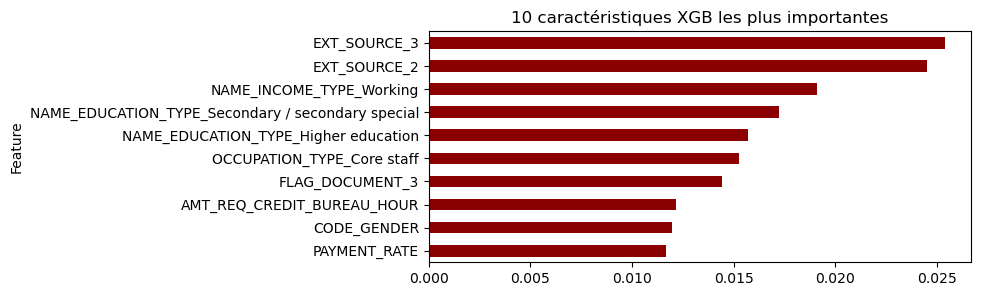

In [26]:
# Visualisation
top_10_features.plot(
    kind="barh",
    x="Feature",
    y="Importance",
    figsize=(7, 3),
    legend=False,
    color="darkred",
)
plt.gca().invert_yaxis()
plt.title("10 caractéristiques XGB les plus importantes")

# Sauvegarder le graphique en tant qu'image avec ajustement de l'espace
plt.savefig("Divers/xgb_feature_importance.png", bbox_inches="tight")

plt.show()

In [27]:
# Liste des 10 principales caractéristiques
top_10_xgb_columns = top_10_features["Feature"].tolist()

# Création d'un nouveau DataFrame avec seulement ces colonnes
df_xgb = df2[top_10_xgb_columns]

In [28]:
df_xgb["TARGET"] = df2["TARGET"]

C:\Users\arken\AppData\Local\Temp\ipykernel_10116\1441802947.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xgb["TARGET"] = df2["TARGET"]


In [29]:
df_xgb.head()

,EXT_SOURCE_3,EXT_SOURCE_2,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_EDUCATION_TYPE_Higher education,OCCUPATION_TYPE_Core staff,FLAG_DOCUMENT_3,AMT_REQ_CREDIT_BUREAU_HOUR,CODE_GENDER,PAYMENT_RATE,TARGET
SK_ID_CURR,,,,,,,,,,,
100002,0.139376,0.262949,True,True,False,False,1,0.000000,0,0.060749,1.0
100003,0.509353,0.622246,False,False,True,True,1,0.000000,1,0.027598,0.0
100004,0.729567,0.555912,True,True,False,False,0,0.000000,0,0.050000,0.0
100006,0.509353,0.650442,True,True,False,False,1,0.005809,1,0.094941,0.0
100007,0.509353,0.322738,True,True,False,True,0,0.000000,0,0.042623,0.0


In [30]:
df_xgb.shape

(307467, 11)

In [31]:
submission_file_name = "../Data/Processed/fichier_xgb.csv"
df_xgb.to_csv(submission_file_name, index=True)

FORET ALEATOIRE

In [32]:
# Séparation des caractéristiques et de la cible
X = df2.drop("TARGET", axis=1)
y = df2["TARGET"]

# Entraînement du modèle Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X, y)

# Extraction de l'importance des caractéristiques
feature_importances_rf = rf_model.feature_importances_

# Création d'un DataFrame pour l'importance des caractéristiques
features_df_rf = pd.DataFrame(
    {"Feature": X.columns, "Importance": feature_importances_rf}
)

# Tri des caractéristiques par importance
features_df_rf = features_df_rf.sort_values(by="Importance", ascending=False)

# Affichage des 10 caractéristiques les plus importantes
top_10_features_rf = features_df_rf.head(10)
top_10_features_rf

,Feature,Importance
31,EXT_SOURCE_2,0.045106
32,EXT_SOURCE_3,0.042256
9,DAYS_BIRTH,0.028346
12,DAYS_ID_PUBLISH,0.027915
11,DAYS_REGISTRATION,0.027497
253,DAYS_EMPLOYED_PERC,0.027211
257,PAYMENT_RATE,0.026499
256,ANNUITY_INCOME_PERC,0.025735
254,INCOME_CREDIT_PERC,0.025152
10,DAYS_EMPLOYED,0.025037


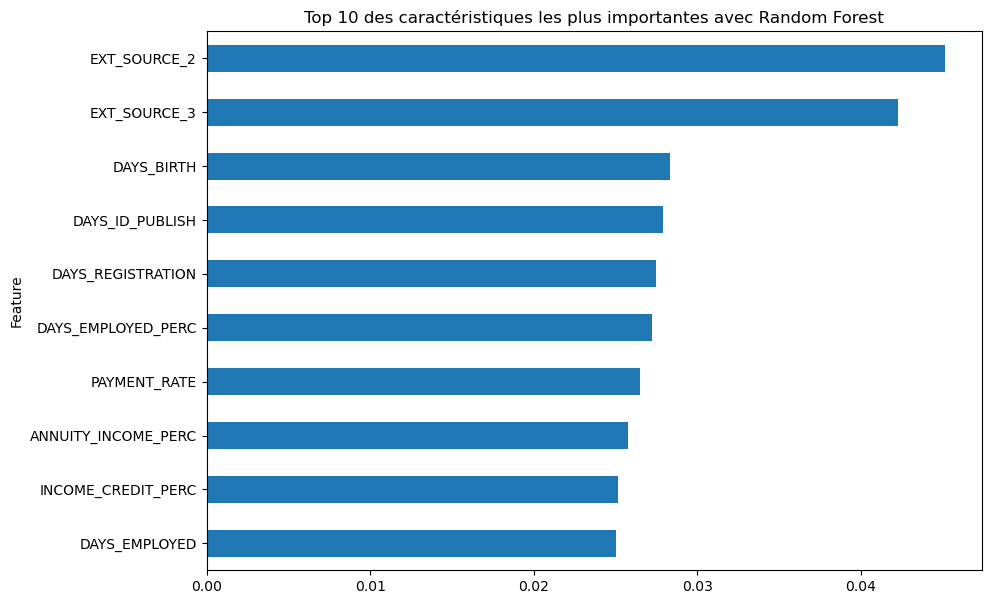

In [33]:
# Visualisation
top_10_features_rf.plot(
    kind="barh", x="Feature", y="Importance", figsize=(10, 7), legend=False
)
plt.gca().invert_yaxis()
plt.title("Top 10 des caractéristiques les plus importantes avec Random Forest")
plt.show()

In [34]:
# Liste des 10 principales caractéristiques
top_10_rf_columns = top_10_features_rf["Feature"].tolist()

# Création d'un nouveau DataFrame avec seulement ces colonnes
df_fa = df2[top_10_rf_columns]

In [35]:
df_fa["TARGET"] = df2["TARGET"]

C:\Users\arken\AppData\Local\Temp\ipykernel_10116\932454460.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fa["TARGET"] = df2["TARGET"]


In [36]:
df_fa.head()

,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_ID_PUBLISH,DAYS_REGISTRATION,DAYS_EMPLOYED_PERC,PAYMENT_RATE,ANNUITY_INCOME_PERC,INCOME_CREDIT_PERC,DAYS_EMPLOYED,TARGET
SK_ID_CURR,,,,,,,,,,,
100002,0.262949,0.139376,-9461,-2120,-3648.0,0.067329,0.060749,0.121978,0.498036,-637.0,1.0
100003,0.622246,0.509353,-16765,-291,-1186.0,0.070862,0.027598,0.132217,0.208736,-1188.0,0.0
100004,0.555912,0.729567,-19046,-2531,-4260.0,0.011814,0.050000,0.100000,0.500000,-225.0,0.0
100006,0.650442,0.509353,-19005,-2437,-9833.0,0.159905,0.094941,0.219900,0.431748,-3039.0,0.0
100007,0.322738,0.509353,-19932,-3458,-4311.0,0.152418,0.042623,0.179963,0.236842,-3038.0,0.0


In [37]:
submission_file_name = "../Data/Processed/fichier_fa.csv"
df_fa.to_csv(submission_file_name, index=True)

In [38]:
gc.collect()

7814

LIGHTGBM

In [39]:
# Séparation des caractéristiques et de la cible
X = df2.drop("TARGET", axis=1)
y = df2["TARGET"]


def clean_column_names(col_name):
    # Liste des caractères spéciaux interdits dans les noms des caractéristiques par LightGBM
    forbidden_characters = "[,{}<>\[\]:]"
    return re.sub(forbidden_characters, "_", col_name)


# Appliquer la fonction de nettoyage aux noms des colonnes
X.columns = [clean_column_names(col) for col in X.columns]

# Entraînement du modèle LightGBM
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X, y)

# Extraction de l'importance des caractéristiques
feature_importances_lgb = lgb_model.feature_importances_

# Création d'un DataFrame pour l'importance des caractéristiques
features_df_lgb = pd.DataFrame(
    {"Feature": X.columns, "Importance": feature_importances_lgb}
)

# Tri par importance
features_df_lgb = features_df_lgb.sort_values(by="Importance", ascending=False)

# Affichage des 10 caractéristiques les plus importantes
top_10_lgb = features_df_lgb.head(10)
top_10_lgb

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 24820, number of negative: 282647
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12625
[LightGBM] [Info] Number of data points in the train set: 307467, number of used features: 243
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080724 -> initscore=-2.432549
[LightGBM] [Info] Start training from score -2.432549


,Feature,Importance
257,PAYMENT_RATE,366
30,EXT_SOURCE_1,213
32,EXT_SOURCE_3,208
31,EXT_SOURCE_2,170
9,DAYS_BIRTH,151
10,DAYS_EMPLOYED,94
6,AMT_ANNUITY,91
12,DAYS_ID_PUBLISH,90
7,AMT_GOODS_PRICE,88
5,AMT_CREDIT,81


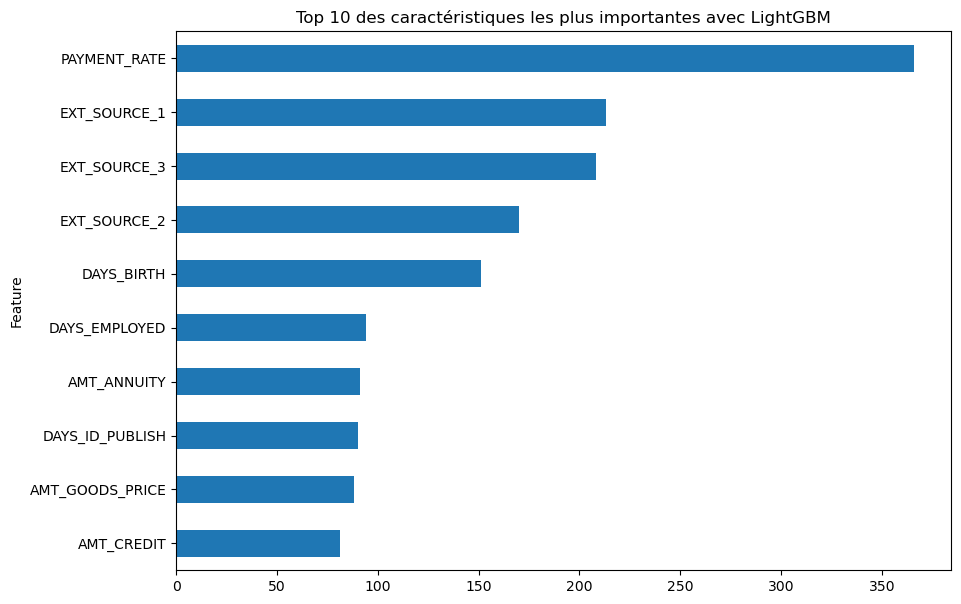

In [40]:
# Visualisation
top_10_lgb.plot(kind="barh", x="Feature", y="Importance", figsize=(10, 7), legend=False)
plt.gca().invert_yaxis()
plt.title("Top 10 des caractéristiques les plus importantes avec LightGBM")
plt.show()

In [41]:
# Liste des 10 principales caractéristiques
top_10_lgb_columns = top_10_lgb["Feature"].tolist()

# Création d'un nouveau DataFrame avec seulement ces colonnes
df_lgbm = df1[top_10_lgb_columns]

In [42]:
df_lgbm["TARGET"] = df2["TARGET"]

C:\Users\arken\AppData\Local\Temp\ipykernel_10116\1999214517.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lgbm["TARGET"] = df2["TARGET"]


In [43]:
df_lgbm.head()

,PAYMENT_RATE,EXT_SOURCE_1,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,DAYS_EMPLOYED,AMT_ANNUITY,DAYS_ID_PUBLISH,AMT_GOODS_PRICE,AMT_CREDIT,TARGET
SK_ID_CURR,,,,,,,,,,,
100002,0.060749,0.083037,0.139376,0.262949,-9461,-637.0,24700.5,-2120,351000.0,406597.5,1.0
100003,0.027598,0.311267,0.509353,0.622246,-16765,-1188.0,35698.5,-291,1129500.0,1293502.5,0.0
100004,0.050000,0.501964,0.729567,0.555912,-19046,-225.0,6750.0,-2531,135000.0,135000.0,0.0
100006,0.094941,0.501964,0.509353,0.650442,-19005,-3039.0,29686.5,-2437,297000.0,312682.5,0.0
100007,0.042623,0.501964,0.509353,0.322738,-19932,-3038.0,21865.5,-3458,513000.0,513000.0,0.0


In [44]:
submission_file_name = "../Data/Processed/fichier_lgbm.csv"
df_lgbm.to_csv(submission_file_name, index=True)